In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from skimage.io import imread
import cv2
import pickle

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Data_PS3/Data_tabular/dataset_image.csv")

In [ ]:
train_df.columns, train_df.shape

(Index(['Unnamed: 0', 'anon_filename', 'rad_decision'], dtype='object'),
 (10000, 3))

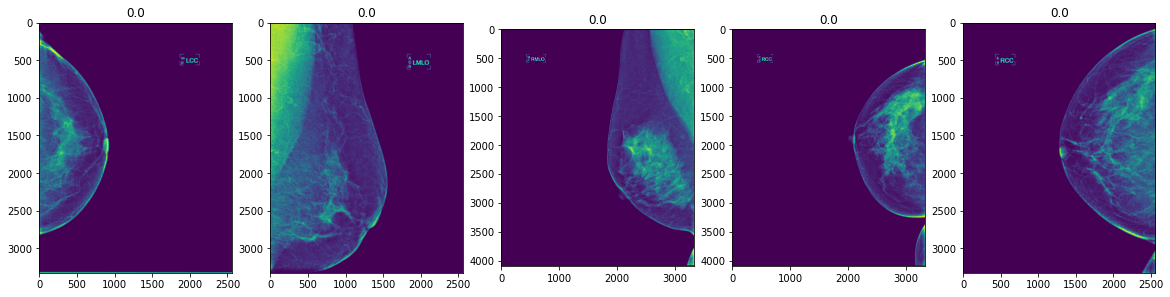

In [ ]:
img_path = '/content/drive/MyDrive/Data_PS3/Data/'

#get the first 5 whale images
images = [(whale_img, whale_label) for (whale_img, whale_label) in zip(train_df.anon_filename[:5], train_df.rad_decision[:5])]

fig, m_axs = plt.subplots(1, len(images), figsize = (20, 10))

#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(imread(os.path.join(img_path,images[ii][0])))
    c_ax.set_title(images[ii][1])

In [ ]:
train_df['rad_decision'].value_counts()

0.0    5000
1.0    5000
Name: rad_decision, dtype: int64




### Model building

In [ ]:
img_path = '/content/drive/MyDrive/Data_PS3/Image_png_normalized/'

img_name=list(train_df['anon_filename'])

abs_file_names = []

for img in img_name:
  img=img.replace("dcm", "png")
  path_name = os.path.join(img_path,img)
  abs_file_names.append(path_name)
  

# update dataframe

train_df['target'] = train_df['rad_decision'].astype(int).astype(str)
train_df['Image'] = abs_file_names



In [ ]:
train_df.head()

,Unnamed: 0,anon_filename,rad_decision,target,Image
0,21455,01929_20990909_L_CC_4.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
1,63483,06130_20990909_L_MLO_5.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
2,55224,05215_20990909_R_MLO_3.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
3,9273,00844_20990909_R_CC_4.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
4,9536,00867_20990909_R_CC_3.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...


In [ ]:
train_df.shape

(10000, 5)

In [ ]:
abs_file_names[0]

'/content/drive/MyDrive/Data_PS3/Image_png_normalized/01929_20990909_L_CC_4.png'

In [3]:
import os
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import keras 
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from keras.models import load_model
#tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})

strategy = tf.distribute.MirroredStrategy()

2.9.2


In [ ]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)

In [5]:
early_stopping = EarlyStopping(monitor="val_loss", patience=15, verbose=1)

In [6]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [7]:
# define model architecture 
from keras.applications import vgg16
input_shape = (224, 224, 3)

def create_model():
  input_shape = (224, 224, 3)
  model = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)
  
  # for layer in model.layers:
  #   if layer.name == 'block5_conv1':
  #     break
  #   layer.trainable = False
    
  for layer in model.layers:
    layer.trainable = False

  # Add a new fully connected layer for the specific task
  x = model.output
  x = tf.keras.layers.Flatten()(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(x)

  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=model.input, outputs=predictions)
  return model

# def create_model():
#   # Create prediction layer for classification of our images
#   x = base_model.output
#   x = Flatten()(x)
#   prediction_layer = Dense(1, activation='sigmoid')(x) 
#   model = Model(inputs=base_model.input, outputs=prediction_layer)

#   return model

In [ ]:
model=create_model()
print(model.summary())

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
train_df.head()

,Unnamed: 0,anon_filename,rad_decision,target,Image
0,21455,01929_20990909_L_CC_4.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
1,63483,06130_20990909_L_MLO_5.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
2,55224,05215_20990909_R_MLO_3.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
3,9273,00844_20990909_R_CC_4.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
4,9536,00867_20990909_R_CC_3.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...


In [ ]:
train_df=train_df.sample(frac=1, random_state=7)
train_df.shape

(10000, 5)

In [ ]:
train_df.head()

,Unnamed: 0,anon_filename,rad_decision,target,Image
1977,64666,06245_20990909_L_MLO_2.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
3880,21255,01915_20990909_R_CC_1.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
52,2929,00256_20990909_L_MLO_1.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
2551,86026,08703_20990909_L_CC_2.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...
2246,44680,04163_20990909_L_CC_2.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_png_norm...


In [ ]:
# augmentation parameters
# you can use preprocessing_function instead of rescale in all generators
# if you are using a pretrained network
train_augmentation_parameters = dict(
    rescale=1.0/255.0
)

# Using the training phase generators 
train_augmenter = ImageDataGenerator(**train_augmentation_parameters)


In [ ]:
# training parameters
BATCH_SIZE = 10000
CLASS_MODE = "binary"
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 20
SEED = 1337

train_consts = {'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }
train_data_generator = train_augmenter.flow_from_dataframe(dataframe=train_df,  x_col='Image', y_col='target',shuffle=False, **train_consts )

Found 10000 validated image filenames belonging to 2 classes.


In [ ]:
X_batch=train_data_generator[0]
X=[]
y=[]

for i,j in zip(X_batch[0], X_batch[1]):
  X.append(i)
  y.append(j)

len(X), len(y)

KeyboardInterrupt: ignored

In [ ]:
len(X), len(y)

NameError: ignored

In [ ]:

path='/content/drive/MyDrive/Data_PS3/Data_normalized_array/'
np.save(path + 'data.npy', np.array(X))
np.save(path + 'labels.npy', np.array(y))

In [ ]:
del X

In [ ]:
import pickle

# save the array to a file
with open('arr.pkl', 'wb') as f:
    pickle.dump(X, f)

In [ ]:
X=np.array(X)

In [ ]:
from keras.utils import to_categorical
y=to_categorical(y)

In [ ]:
X.shape

(64, 224, 224, 3)

In [ ]:
Y = train_df['rad_decision']                        
skf = StratifiedKFold(5, random_state = 42, shuffle = True) 

In [ ]:
# training parameters
BATCH_SIZE = 64
CLASS_MODE = "categorical"
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 20
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/VGG_model/'
fold_var = 1

for train_index, val_index in skf.split(train_df,Y):
  print('Fold {}-------------------------------------------------'.format(fold_var))

  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_data_generator = train_augmenter.flow_from_dataframe(dataframe=training_data,  x_col='Image', y_col='target', **train_consts, prefetch=tf.data.experimental.AUTOTUNE )
 
  valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=validation_data, x_col='Image', y_col='target', **train_consts, prefetch=tf.data.experimental.AUTOTUNE)

  # CREATE CALLBACKS  
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 5,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')
  
  callbacks_list = [checkpoint, reduce_lr, early_stopping]

    # CREATE NEW MODEL
  with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
	# COMPILE NEW MODEL
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=10e-4), metrics=['accuracy'])
  # FIT THE MODEL
  history = model.fit(train_data_generator,epochs=EPOCHS, callbacks=callbacks_list, validation_data=valid_data_generator)	

	# This saves the best model
	
 
  histories.append(history.history)

  model.load_weights("/content/drive/MyDrive/Data_PS3/Save_dir/VGG_model/model_"+str(fold_var)+".h5")
	
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  pred = model.predict(valid_data_generator)
  folds_y.append(validation_data['rad_decision'])
  folds_y_prob.append(pred)
  folds_y_pred.append(np.round(pred))

  del model, results, pred, history
  
  break

  fold_var += 1

Fold 1-------------------------------------------------
Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.7471 - accuracy: 0.5181 
Epoch 1: val_accuracy improved from -inf to 0.53200, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/VGG_model/model_1.h5
125/125 [==============================] - 2446s 20s/step - loss: 0.7471 - accuracy: 0.5181 - val_loss: 0.7164 - val_accuracy: 0.5320 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.5901
Epoch 2: val_accuracy improved from 0.53200 to 0.54050, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/VGG_model/model_1.h5
125/125 [==============================] - 780s 6s/step - loss: 0.6812 - accuracy: 0.5901 - val_loss: 0.7112 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.

ValueError: ignored

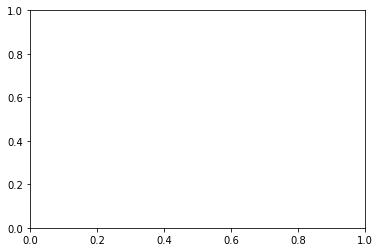

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,EPOCHS+1)
training_loss = histories[0]['val_accuracy']
validation_loss = histories[0]["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### InceptionV3

In [ ]:
# define model architecture 
from keras.applications.inception_v3 import InceptionV3

def create_model():
  input_shape = (224, 224, 3)
  basemodel = InceptionV3(input_shape= input_shape,
                          include_top = False,
                          weights = 'imagenet')
  
  for layer in basemodel.layers:
    layer.trainable = False
  
  # Add a new fully connected layer for the specific task
  x = basemodel.output
  x = tf.keras.layers.Flatten()(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(x)

  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=basemodel.input, outputs=predictions)

  return model


In [ ]:
# training parameters
BATCH_SIZE = 64
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 15
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/Inception_model/'
fold_var = 1

for train_index, val_index in skf.split(train_df,Y):
  print('Fold {}-------------------------------------------------'.format(fold_var))

  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_data_generator = train_augmenter.flow_from_dataframe(dataframe=training_data,  x_col='Image', y_col='target', **train_consts, prefetch=tf.data.experimental.AUTOTUNE)
 
  valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=validation_data, x_col='Image', y_col='target', **train_consts, prefetch=tf.data.experimental.AUTOTUNE)

  # CREATE CALLBACKS  
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]#, early_stopping]

    # CREATE NEW MODEL
  #with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = create_model()
	# COMPILE NEW MODEL
  model.compile(loss='categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
  # FIT THE MODEL
  history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)	

	# This saves the best model
	
 
  histories.append(history.history)

  model.load_weights("/content/drive/MyDrive/Data_PS3/Save_dir/Inception_model/model_"+str(fold_var)+".h5")
	
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  pred = model.predict(valid_data_generator)
  folds_y.append(validation_data['rad_decision'])
  folds_y_prob.append(pred)
  folds_y_pred.append(np.round(pred))

  del model, results, pred, history
  
  break

  fold_var += 1

Fold 1-------------------------------------------------
Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/15
125/125 [==============================] - ETA: 0s - loss: 0.8596 - accuracy: 0.5134  
Epoch 1: val_accuracy improved from -inf to 0.52150, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/Inception_model/model_1.h5
125/125 [==============================] - 9761s 78s/step - loss: 0.8596 - accuracy: 0.5134 - val_loss: 0.8367 - val_accuracy: 0.5215
Epoch 2/15
125/125 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.5835 
Epoch 2: val_accuracy improved from 0.52150 to 0.54750, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/Inception_model/model_1.h5
125/125 [==============================] - 1952s 16s/step - loss: 0.7187 - accuracy: 0.5835 - val_loss: 0.7980 - val_accuracy: 0.5475
Epoch 3/15
125/12

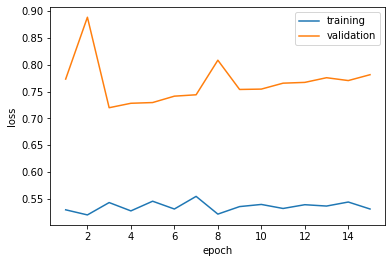

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,EPOCHS+1)
training_loss = histories[0]['val_accuracy']
validation_loss = histories[0]["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
# define model architecture 
from keras.applications.mobilenet import MobileNet

# initialize the base model

def create_model():
  input_shape = (224, 224, 3)
  basemodel = MobileNet(input_shape=input_shape,
                          include_top = False,
                          weights = 'imagenet')

  
  for layer in basemodel.layers:
    layer.trainable = False
  
  # Add a new fully connected layer for the specific task
  x = basemodel.output
  x = tf.keras.layers.Flatten()(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(x)

  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=basemodel.input, outputs=predictions)
  return model


In [ ]:
# training parameters
BATCH_SIZE = 64
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 20
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/MobilNet_model/'
fold_var = 1

for train_index, val_index in skf.split(train_df,Y):
  print('Fold {}-------------------------------------------------'.format(fold_var))

  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_data_generator = train_augmenter.flow_from_dataframe(dataframe=training_data,  x_col='Image', y_col='target', **train_consts)
 
  valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=validation_data, x_col='Image', y_col='target', **train_consts)

  # CREATE CALLBACKS  
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]#, early_stopping]

    # CREATE NEW MODEL
  with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
	# COMPILE NEW MODEL
    model.compile(loss='categorical_crossentropy', optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])
  # FIT THE MODEL
    history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)	

	# This saves the best model
	
 
  histories.append(history.history)

  model.load_weights("/content/drive/MyDrive/Data_PS3/Save_dir/MobilNet_model/model_"+str(fold_var)+".h5")
	
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  pred = model.predict(valid_data_generator)
  folds_y.append(validation_data['rad_decision'])
  folds_y_prob.append(pred)
  folds_y_pred.append(np.round(pred))

  del model, results, pred, history
  
  break

  fold_var += 1

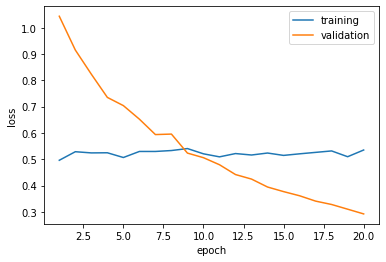

In [ ]:


%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,EPOCHS+1)
training_loss = histories[0]['val_accuracy']
validation_loss = histories[0]["loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

#### ResNet50

In [ ]:
from keras.applications import ResNet50

def create_model():
  input_shape = (224, 224, 3)
  basemodel = ResNet50(input_shape=input_shape,
                          include_top = False,
                          weights = 'imagenet')

  
  for layer in basemodel.layers:
    layer.trainable = False
  
  x = basemodel.output
  x = tf.keras.layers.Flatten()(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(x)

  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=basemodel.input, outputs=predictions)
  return model

In [ ]:
model =create_model()
print(model.summary())

94765736/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
# training parameters
BATCH_SIZE = 64
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 15
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/ResNet_model/'
fold_var = 1

for train_index, val_index in skf.split(train_df,Y):
  print('Fold {}-------------------------------------------------'.format(fold_var))

  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_data_generator = train_augmenter.flow_from_dataframe(dataframe=training_data,  x_col='Image', y_col='target', **train_consts, prefetch=tf.data.experimental.AUTOTUNE)
 
  valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=validation_data, x_col='Image', y_col='target', **train_consts, prefetch=tf.data.experimental.AUTOTUNE)

  # CREATE CALLBACKS  
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]#, early_stopping]

    # CREATE NEW MODEL
  with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
	# COMPILE NEW MODEL
    model.compile(loss='categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
  # FIT THE MODEL
  history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)	

	# This saves the best model
	
  histories.append(history.history)

  model.load_weights("/content/drive/MyDrive/Data_PS3/Save_dir/ResNet_model/model_"+str(fold_var)+".h5")
	
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  pred = model.predict(valid_data_generator)
  folds_y.append(validation_data['rad_decision'])
  folds_y_prob.append(pred)
  folds_y_pred.append(np.round(pred))

  del model, results, pred, history
  
  break

  fold_var += 1

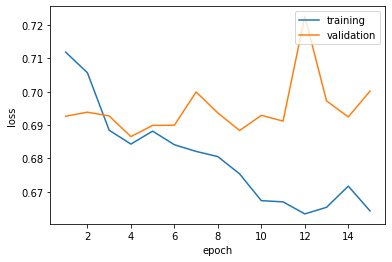

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,EPOCHS+1)
training_loss = histories[0]['loss']
validation_loss = histories[0]["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

#### Fine-tuning of last convolution layer

In [ ]:
from keras.applications import ResNet50

def create_model():
  input_shape = (224, 224, 3)
  basemodel = ResNet50(input_shape=input_shape,
                          include_top = False,
                          weights = 'imagenet')

  
  for layer in basemodel.layers[:-4]:
    layer.trainable = False
  
  x = basemodel.output
  x = GlobalAveragePooling2D()(x)
  #x = Dropout(0.5)(x)
  #predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=basemodel.input, outputs=predictions)


  return model

In [ ]:
model =create_model()
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# training parameters
BATCH_SIZE = 64
CLASS_MODE = 'binary'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 20
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/ResNetF1_model/'
fold_var = 1

for train_index, val_index in skf.split(train_df,Y):
  print('Fold {}-------------------------------------------------'.format(fold_var))

  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_data_generator = train_augmenter.flow_from_dataframe(dataframe=training_data,  x_col='Image', y_col='target', **train_consts, prefetch=tf.data.experimental.AUTOTUNE)
 
  valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=validation_data, x_col='Image', y_col='target', **train_consts, prefetch=tf.data.experimental.AUTOTUNE)

  # CREATE CALLBACKS  
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]#, early_stopping]

    # CREATE NEW MODEL
  with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
	# COMPILE NEW MODEL
    model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
  # FIT THE MODEL
  history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)	

	# This saves the best model
	
  histories.append(history.history)

  model.load_weights("/content/drive/MyDrive/Data_PS3/Save_dir/ResNetF1_model/model_"+str(fold_var)+".h5")
	
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  pred = model.predict(valid_data_generator)
  folds_y.append(validation_data['rad_decision'])
  folds_y_prob.append(pred)
  folds_y_pred.append(np.round(pred))

  del model, results, pred, history
  
  break

  fold_var += 1

Fold 1-------------------------------------------------
Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5270 
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/ResNetF1_model/model_1.h5
125/125 [==============================] - 2936s 23s/step - loss: 0.6964 - accuracy: 0.5270 - val_loss: 0.7121 - val_accuracy: 0.5000
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5374
Epoch 2: val_accuracy improved from 0.50000 to 0.50050, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/ResNetF1_model/model_1.h5
125/125 [==============================] - 782s 6s/step - loss: 0.6896 - accuracy: 0.5374 - val_loss: 0.7155 - val_accuracy: 0.5005
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.6836 - accuracy:

### DenseNet201

In [ ]:
from keras.applications import DenseNet201

def create_model():
  input_shape = (224, 224, 3)
  basemodel = DenseNet201(input_shape=input_shape,
                          include_top = False,
                          weights = 'imagenet')

  
  for layer in basemodel.layers:
    layer.trainable = False
  
  x = basemodel.output
  x = tf.keras.layers.Flatten()(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=basemodel.input, outputs=predictions)
  return model


In [ ]:
# training parameters
BATCH_SIZE = 64
CLASS_MODE = 'binary'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 15
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/DensNet_model/'
fold_var = 1

for train_index, val_index in skf.split(train_df,Y):
  print('Fold {}-------------------------------------------------'.format(fold_var))

  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_data_generator = train_augmenter.flow_from_dataframe(dataframe=training_data,  x_col='Image', y_col='target', **train_consts)
 
  valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=validation_data, x_col='Image', y_col='target', **train_consts)

  # CREATE CALLBACKS  
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]#, early_stopping]

    # CREATE NEW MODEL
  with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
	# COMPILE NEW MODEL
    model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
  # FIT THE MODEL
    history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)	

	# This saves the best model
	
 
  histories.append(history.history)

  model.load_weights("/content/drive/MyDrive/Data_PS3/Save_dir/DensNet_model/model_"+str(fold_var)+".h5")
	
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  pred = model.predict(valid_data_generator)
  folds_y.append(validation_data['rad_decision'])
  folds_y_prob.append(pred)
  folds_y_pred.append(np.round(pred))

  del model, results, pred, history
  
  break

  fold_var += 1

Fold 1-------------------------------------------------
Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/15
125/125 [==============================] - ETA: 0s - loss: 0.7819 - accuracy: 0.5179
Epoch 1: val_accuracy improved from -inf to 0.53650, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/DensNet_model/model_1.h5
125/125 [==============================] - 790s 6s/step - loss: 0.7819 - accuracy: 0.5179 - val_loss: 0.7775 - val_accuracy: 0.5365
Epoch 2/15
125/125 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.5822
Epoch 2: val_accuracy did not improve from 0.53650
125/125 [==============================] - 764s 6s/step - loss: 0.7013 - accuracy: 0.5822 - val_loss: 0.8040 - val_accuracy: 0.5305
Epoch 3/15
125/125 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.6137
Epoch 3: val_accura

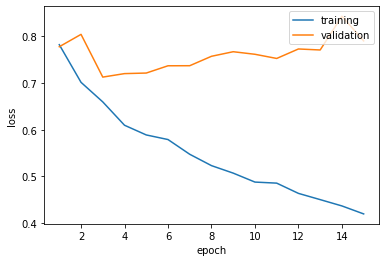

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,EPOCHS+1)
training_loss = histories[0]['loss']
validation_loss = histories[0]["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### DenseNet training of last conv layer

In [ ]:
from keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1, l2

def create_model():
  input_shape = (224, 224, 3)
  basemodel = DenseNet201(input_shape=input_shape,
                          include_top = False,
                          weights = 'imagenet')

  
  for layer in basemodel.layers[:-4]:
    layer.trainable = False
  
  x = basemodel.output
  x = GlobalAveragePooling2D()(x)
  #x = Dropout(0.5)(x)
  #predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=basemodel.input, outputs=predictions)
  return model


In [ ]:
model = create_model()
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input_6[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                           

In [ ]:
# training parameters
BATCH_SIZE = 64
CLASS_MODE = 'binary'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 50
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/DensNetF2_model/'
fold_var = 1

for train_index, val_index in skf.split(train_df,Y):
  print('Fold {}-------------------------------------------------'.format(fold_var))

  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_data_generator = train_augmenter.flow_from_dataframe(dataframe=training_data,  x_col='Image', y_col='target', **train_consts)
 
  valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=validation_data, x_col='Image', y_col='target', **train_consts)

  # CREATE CALLBACKS  
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]#, early_stopping]

    # CREATE NEW MODEL
  with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
	# COMPILE NEW MODEL
    model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
  # FIT THE MODEL
    history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)	

	# This saves the best model
	
 
  histories.append(history.history)

  model.load_weights("/content/drive/MyDrive/Data_PS3/Save_dir/DensNetF2_model/model_"+str(fold_var)+".h5")
	
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  pred = model.predict(valid_data_generator)
  folds_y.append(validation_data['rad_decision'])
  folds_y_prob.append(pred)
  folds_y_pred.append(np.round(pred))

  del model, results, pred, history
  
  break

  fold_var += 1

Fold 1-------------------------------------------------
Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.5076
Epoch 1: val_accuracy improved from -inf to 0.50600, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/DensNetF2_model/model_1.h5
125/125 [==============================] - 820s 6s/step - loss: 0.7054 - accuracy: 0.5076 - val_loss: 0.7115 - val_accuracy: 0.5060
Epoch 2/50
125/125 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.5228
Epoch 2: val_accuracy improved from 0.50600 to 0.52550, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/DensNetF2_model/model_1.h5
125/125 [==============================] - 815s 7s/step - loss: 0.6963 - accuracy: 0.5228 - val_loss: 0.6986 - val_accuracy: 0.5255
Epoch 3/50
125/125 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 

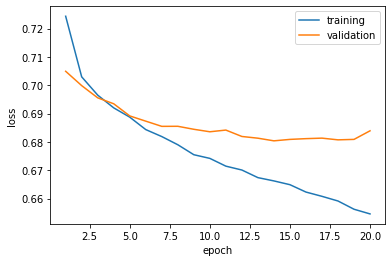

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,EPOCHS+1)
training_loss = histories[0]['loss']
validation_loss = histories[0]["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

##### Vision Transformer (ViT) Fine-tuning

In [ ]:
!pip install --quiet vit-keras

  Preparing metadata (setup.py) ... done


In [ ]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from vit_keras import vit

In [ ]:
IMAGE_SIZE=224
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'sigmoid',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

353253686/353253686 [==============================] - 4s 0us/step


/usr/local/lib/python3.8/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [ ]:
train_augmentation_parameters = dict(
    validation_split = 0.2,
    rescale=1.0/255.0)

# Using the training phase generators 
train_augmenter = ImageDataGenerator(**train_augmentation_parameters)

In [ ]:
# training parameters
IMAGE_SIZE=224
BATCH_SIZE = 64
CLASS_MODE = 'binary'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 15
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

train_data_generator = train_augmenter.flow_from_dataframe(dataframe=train_df, subset = 'training',  x_col='Image', y_col='target', target_size = (IMAGE_SIZE, IMAGE_SIZE), **train_consts)
 
valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=train_df, subset = 'validation', x_col='Image', y_col='target', target_size = (IMAGE_SIZE, IMAGE_SIZE), **train_consts)

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [ ]:
learning_rate = 1e-4
fold_var=1
save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/VIT_model/'

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

STEP_SIZE_TRAIN = train_data_generator.n // train_data_generator.batch_size
STEP_SIZE_VALID = valid_data_generator.n // valid_data_generator.batch_size

checkpointer = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var),
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [checkpointer]

with strategy.scope():
  IMAGE_SIZE=224
  vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'sigmoid',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)
  model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, 'sigmoid')
    ],
    name = 'vision_transformer')
  
  model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

  history= model.fit(x = train_data_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_data_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

histories.append(history.history)



353253686/353253686 [==============================] - 29s 0us/step


/usr/local/lib/python3.8/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Epoch 1/15
125/125 [==============================] - ETA: 0s - loss: 0.7935 - accuracy: 0.5125  
Epoch 1: val_accuracy improved from -inf to 0.25403, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/VIT_model/model_1.h5


OSError: ignored

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,EPOCHS+1)
training_loss = histories[0]['loss']
validation_loss = histories[0]["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

#### Essaye sur les données sans muscle pectoral

In [ ]:
img_path = '/content/drive/MyDrive/Data_PS3/Image_without_pecto/'

img_name=list(train_df['anon_filename'])

abs_file_names = []

for img in img_name:
  img=img.replace("dcm", "png")
  path_name = os.path.join(img_path,img)
  abs_file_names.append(path_name)
  

# update dataframe

train_df['target'] = train_df['rad_decision'].astype(int).astype(str)
train_df['Image'] = abs_file_names


In [ ]:
train_df=train_df.sample(frac=1, random_state=7)
train_df.shape

(10000, 5)

In [ ]:
train_df.head()

,Unnamed: 0,anon_filename,rad_decision,target,Image
1977,64666,06245_20990909_L_MLO_2.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_without_...
3880,21255,01915_20990909_R_CC_1.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_without_...
52,2929,00256_20990909_L_MLO_1.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_without_...
2551,86026,08703_20990909_L_CC_2.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_without_...
2246,44680,04163_20990909_L_CC_2.dcm,0.0,0,/content/drive/MyDrive/Data_PS3/Image_without_...


In [ ]:
from keras.applications import DenseNet201

def create_model():
  input_shape = (224, 224, 3)
  basemodel = DenseNet201(input_shape=input_shape,
                          include_top = False,
                          weights = 'imagenet')

  
  for layer in basemodel.layers:
    layer.trainable = False
  
  x = basemodel.output
  x = tf.keras.layers.Flatten()(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=basemodel.input, outputs=predictions)
  return model


In [ ]:
# training parameters
BATCH_SIZE = 64
CLASS_MODE = 'binary'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 15
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/DensNetPec_model/'
fold_var = 1

for train_index, val_index in skf.split(train_df,Y):
  print('Fold {}-------------------------------------------------'.format(fold_var))

  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_data_generator = train_augmenter.flow_from_dataframe(dataframe=training_data,  x_col='Image', y_col='target', **train_consts)
 
  valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=validation_data, x_col='Image', y_col='target', **train_consts)

  # CREATE CALLBACKS  
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]#, early_stopping]

    # CREATE NEW MODEL
  with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
	# COMPILE NEW MODEL
    model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
  # FIT THE MODEL
    history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)	

	# This saves the best model
	
 
  histories.append(history.history)

  model.load_weights("/content/drive/MyDrive/Data_PS3/Save_dir/DensNetPec_model/model_"+str(fold_var)+".h5")
	
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  pred = model.predict(valid_data_generator)
  folds_y.append(validation_data['rad_decision'])
  folds_y_prob.append(pred)
  folds_y_pred.append(np.round(pred))

  del model, results, pred, history
  
  break

  fold_var += 1

Fold 1-------------------------------------------------
Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
74836368/74836368 [==============================] - 3s 0us/step
Epoch 1/15
125/125 [==============================] - ETA: 0s - loss: 0.7729 - accuracy: 0.5189 
Epoch 1: val_accuracy improved from -inf to 0.52350, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/DensNetPec_model/model_1.h5
125/125 [==============================] - 5058s 40s/step - loss: 0.7729 - accuracy: 0.5189 - val_loss: 0.7428 - val_accuracy: 0.5235
Epoch 2/15
125/125 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.5774
Epoch 2: val_accuracy did not improve from 0.52350
125/125 [==============================] - 350s 3s/step - loss: 0.6904 - accuracy: 0.5774 - val_loss: 0.7350 - val_accuracy: 0.5215
Epoch 3/15
125/125 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.6185
Epoch 3: val_

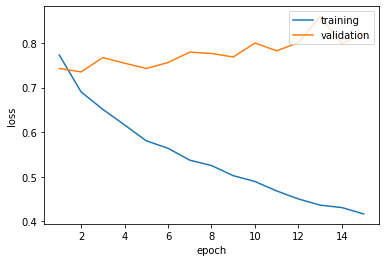

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,EPOCHS+1)
training_loss = histories[0]['loss']
validation_loss = histories[0]["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
from keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1, l2

def create_model():
  input_shape = (224, 224, 3)
  basemodel = DenseNet201(input_shape=input_shape,
                          include_top = False,
                          weights = 'imagenet')

  
  for layer in basemodel.layers[:-4]:
    layer.trainable = False
  
  x = basemodel.output
  x = GlobalAveragePooling2D()(x)
  #x = Dropout(0.5)(x)
  #predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=basemodel.input, outputs=predictions)
  return model


In [ ]:
model = create_model()
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_10 (ZeroPadding  (None, 230, 230, 3)  0          ['input_6[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_10[0][0]']      
                                )                                                           

In [ ]:
# training parameters
BATCH_SIZE = 64
CLASS_MODE = 'binary'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 30
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/DensNetF2_model/'
fold_var = 1

for train_index, val_index in skf.split(train_df,Y):
  print('Fold {}-------------------------------------------------'.format(fold_var))

  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_data_generator = train_augmenter.flow_from_dataframe(dataframe=training_data,  x_col='Image', y_col='target', **train_consts)
 
  valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=validation_data, x_col='Image', y_col='target', **train_consts)

  # CREATE CALLBACKS  
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]#, early_stopping]

    # CREATE NEW MODEL
  with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
	# COMPILE NEW MODEL
    model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
  # FIT THE MODEL
    history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)	

	# This saves the best model
	
 
  histories.append(history.history)

  model.load_weights("/content/drive/MyDrive/Data_PS3/Save_dir/DensNetF2_model/model_"+str(fold_var)+".h5")
	
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  pred = model.predict(valid_data_generator)
  folds_y.append(validation_data['rad_decision'])
  folds_y_prob.append(pred)
  folds_y_pred.append(np.round(pred))

  del model, results, pred, history
  
  break

  fold_var += 1

Fold 1-------------------------------------------------
Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 0.7202 - accuracy: 0.5058
Epoch 1: val_accuracy improved from -inf to 0.51050, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/DensNetF2_model/model_1.h5
125/125 [==============================] - 378s 3s/step - loss: 0.7202 - accuracy: 0.5058 - val_loss: 0.7049 - val_accuracy: 0.5105
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 0.7033 - accuracy: 0.5228
Epoch 2: val_accuracy improved from 0.51050 to 0.51700, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/DensNetF2_model/model_1.h5
125/125 [==============================] - 347s 3s/step - loss: 0.7033 - accuracy: 0.5228 - val_loss: 0.7039 - val_accuracy: 0.5170
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 

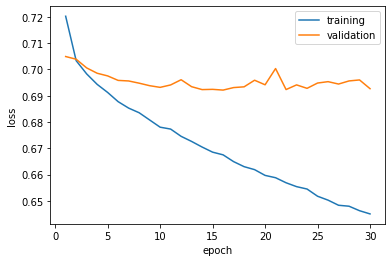

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,EPOCHS+1)
training_loss = histories[0]['loss']
validation_loss = histories[0]["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
from keras.applications import ResNet50

def create_model():
  input_shape = (224, 224, 3)
  basemodel = ResNet50(input_shape=input_shape,
                          include_top = False,
                          weights = 'imagenet')

  
  for layer in basemodel.layers:
    layer.trainable = False
  
  x = basemodel.output
  x = tf.keras.layers.Flatten()(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=basemodel.input, outputs=predictions)

  return model

In [ ]:
# training parameters
BATCH_SIZE = 64
CLASS_MODE = 'binary'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS =20 
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/ResNetPe_model/'
fold_var = 1

for train_index, val_index in skf.split(train_df,Y):
  print('Fold {}-------------------------------------------------'.format(fold_var))

  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_data_generator = train_augmenter.flow_from_dataframe(dataframe=training_data,  x_col='Image', y_col='target', **train_consts, prefetch=tf.data.experimental.AUTOTUNE)
 
  valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=validation_data, x_col='Image', y_col='target', **train_consts, prefetch=tf.data.experimental.AUTOTUNE)

  # CREATE CALLBACKS  
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]#, early_stopping]

    # CREATE NEW MODEL
  with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
	# COMPILE NEW MODEL
    model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
  # FIT THE MODEL
  history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)	

	# This saves the best model
	
  histories.append(history.history)

  model.load_weights("/content/drive/MyDrive/Data_PS3/Save_dir/ResNetPe_model/model_"+str(fold_var)+".h5")
	
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  pred = model.predict(valid_data_generator)
  folds_y.append(validation_data['rad_decision'])
  folds_y_prob.append(pred)
  folds_y_pred.append(np.round(pred))

  del model, results, pred, history
  
  break

  fold_var += 1

Fold 1-------------------------------------------------
Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.7136 - accuracy: 0.5090
Epoch 1: val_accuracy improved from -inf to 0.50300, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/ResNetPe_model/model_1.h5
125/125 [==============================] - 359s 3s/step - loss: 0.7136 - accuracy: 0.5090 - val_loss: 0.7000 - val_accuracy: 0.5030
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.5291
Epoch 2: val_accuracy improved from 0.50300 to 0.51350, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/ResNetPe_model/model_1.h5
125/125 [==============================] - 351s 3s/step - loss: 0.6972 - accuracy: 0.5291 - val_loss: 0.6996 - val_accuracy: 0.5135
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.

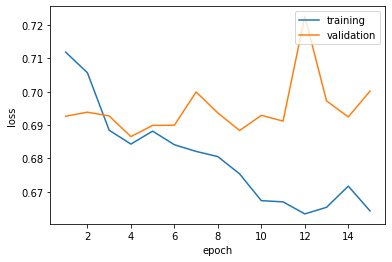

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,EPOCHS+1)
training_loss = histories[0]['loss']
validation_loss = histories[0]["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

#### MobilNet

In [ ]:
# define model architecture 
from keras.applications.mobilenet import MobileNet

# initialize the base model

def create_model():
  input_shape = (224, 224, 3)
  basemodel = MobileNet(input_shape=input_shape,
                          include_top = False,
                          weights = 'imagenet')

  
  for layer in basemodel.layers:
    layer.trainable = False
  
  # Add a new fully connected layer for the specific task
  x = basemodel.output
  x = tf.keras.layers.Flatten()(x)
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  # Create a new model with the pre-trained model and the new fully connected layer
  model = tf.keras.Model(inputs=basemodel.input, outputs=predictions)
  return model


In [ ]:
# training parameters
BATCH_SIZE = 64
CLASS_MODE = 'binary'
COLOR_MODE = 'rgb'
TARGET_SIZE = (224, 224)
EPOCHS = 20
SEED = 1337

train_consts = { 'seed': SEED, 'batch_size': BATCH_SIZE, 'class_mode': CLASS_MODE, 'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE }

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
folds_y = []
folds_y_pred = []
folds_y_prob = []
histories= []

save_dir = '/content/drive/MyDrive/Data_PS3/Save_dir/MobilNetPe_model/'
fold_var = 1

for train_index, val_index in skf.split(train_df,Y):
  print('Fold {}-------------------------------------------------'.format(fold_var))

  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_data_generator = train_augmenter.flow_from_dataframe(dataframe=training_data,  x_col='Image', y_col='target', **train_consts)
 
  valid_data_generator = train_augmenter.flow_from_dataframe(dataframe=validation_data, x_col='Image', y_col='target', **train_consts)

  # CREATE CALLBACKS  
  checkpoint = ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
  
  callbacks_list = [checkpoint]#, early_stopping]

    # CREATE NEW MODEL
  with strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
	# COMPILE NEW MODEL
    model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy'])
  # FIT THE MODEL
    history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)	

	# This saves the best model
	
 
  histories.append(history.history)

  model.load_weights("/content/drive/MyDrive/Data_PS3/Save_dir/MobilNetPe_model/model_"+str(fold_var)+".h5")
	
  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])
  pred = model.predict(valid_data_generator)
  folds_y.append(validation_data['rad_decision'])
  folds_y_prob.append(pred)
  folds_y_pred.append(np.round(pred))

  del model, results, pred, history
  
  break

  fold_var += 1

Fold 1-------------------------------------------------
Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
17225924/17225924 [==============================] - 1s 0us/step
Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 1.0841 - accuracy: 0.5132 
Epoch 1: val_accuracy improved from -inf to 0.51300, saving model to /content/drive/MyDrive/Data_PS3/Save_dir/MobilNetPe_model/model_1.h5
125/125 [==============================] - 4824s 39s/step - loss: 1.0841 - accuracy: 0.5132 - val_loss: 1.1367 - val_accuracy: 0.5130
Epoch 2/20
125/125 [==============================] - ETA: 0s - loss: 0.9432 - accuracy: 0.5635
Epoch 2: val_accuracy did not improve from 0.51300
125/125 [==============================] - 331s 3s/step - loss: 0.9432 - accuracy: 0.5635 - val_loss: 1.0551 - val_accuracy: 0.5085
Epoch 3/20
125/125 [==============================] - ETA: 0s - loss: 0.8354 - accuracy: 0.5855
Epoch 3: val_

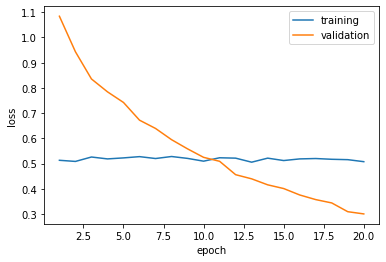

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,EPOCHS+1)
training_loss = histories[0]['val_accuracy']
validation_loss = histories[0]["loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()